In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Memory optimization
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

Using device: cpu


In [ ]:
# Load Veltri dataset
veltri_train = pd.read_csv('veltri_train.csv')
veltri_val = pd.read_csv('veltri_val.csv')
veltri_test = pd.read_csv('veltri_test.csv')

# Load LMPred dataset
lmpred_train = pd.read_csv('lmpred_train.csv')
lmpred_val = pd.read_csv('lmpred_val.csv')
lmpred_test = pd.read_csv('lmpred_test.csv')

print("=== Dataset Sizes ===")
print(f"Veltri - Train: {len(veltri_train)}, Val: {len(veltri_val)}, Test: {len(veltri_test)}")
print(f"LMPred - Train: {len(lmpred_train)}, Val: {len(lmpred_val)}, Test: {len(lmpred_test)}")

=== Dataset Sizes ===
Veltri - Train: 1424, Val: 708, Test: 1424
LMPred - Train: 3005, Val: 1504, Test: 3007


In [ ]:
# Test with a sample
sample_seq = veltri_train['sequence'].iloc[0]
print(f"\n=== ESM-2 Sequence Format ===")
print(f"Original: {sample_seq}")
print(f"For ESM-2: {sample_seq}")
print("Note: ESM-2 handles sequences without spaces")


=== ESM-2 Sequence Format ===
Original: QNVMGRGIALPGMANPQMFQRASTDLEEETADVHAEPEQNPQVSKAPQRARGPRGKRLPKAIKE
For ESM-2: QNVMGRGIALPGMANPQMFQRASTDLEEETADVHAEPEQNPQVSKAPQRARGPRGKRLPKAIKE
Note: ESM-2 handles sequences without spaces


In [ ]:
class ESM2Dataset(Dataset):
    """
    PyTorch Dataset for ESM-2
    """
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.sequences = dataframe['sequence'].values
        self.labels = dataframe['label'].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Get sequence and label
        sequence = self.sequences[idx]
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            sequence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
class ESM2Classifier(nn.Module):
    """
    ESM-2 + Classification Head
    """
    def __init__(self, model_name="facebook/esm2_t6_8M_UR50D", n_classes=2, dropout=0.3, freeze_esm=False):
        super(ESM2Classifier, self).__init__()

        # Load pre-trained ESM-2
        # Options:
        # - esm2_t6_8M_UR50D (8M params, 320 dim) - fastest
        # - esm2_t12_35M_UR50D (35M params, 480 dim)
        # - esm2_t30_150M_UR50D (150M params, 640 dim)
        # - esm2_t33_650M_UR50D (650M params, 1280 dim) - best but slowest

        self.esm = EsmModel.from_pretrained(model_name)

        # Get hidden size based on model
        hidden_size = self.esm.config.hidden_size
        print(f"ESM-2 model: {model_name}")
        print(f"Hidden size: {hidden_size}")

        # Freeze ESM parameters if specified
        if freeze_esm:
            for param in self.esm.parameters():
                param.requires_grad = False

        # Lightweight classification head
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Get ESM embeddings
        outputs = self.esm(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token embedding (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Dropout + classify
        x = self.dropout(cls_embedding)
        logits = self.classifier(x)

        return logits

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device, scaler):
    """
    Train for one epoch with mixed precision
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Track metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        # Clear cache periodically
        if len(all_preds) % 5 == 0:
            torch.cuda.empty_cache()

        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

    return metrics

In [ ]:
def train_esm2_model(train_df, val_df, test_df, dataset_name,
                     model_name="facebook/esm2_t6_8M_UR50D",
                     batch_size=4, epochs=5, learning_rate=2e-5,
                     freeze_esm=False, use_scheduler=True):
    """
    Complete training pipeline for ESM-2
    """
    print(f"\n{'='*60}")
    print(f"Training ESM-2 Model: {dataset_name}")
    print(f"{'='*60}")
    print(f"Model: {model_name}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Freeze ESM: {freeze_esm}")
    print(f"Use scheduler: {use_scheduler}")

    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()

    # Load tokenizer
    print("\nLoading ESM-2 tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create datasets
    print("Creating datasets...")
    train_dataset = ESM2Dataset(train_df, tokenizer, max_length=256)
    val_dataset = ESM2Dataset(val_df, tokenizer, max_length=256)
    test_dataset = ESM2Dataset(test_df, tokenizer, max_length=256)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    print("\nInitializing ESM-2 model...")
    model = ESM2Classifier(model_name=model_name, n_classes=2, dropout=0.3, freeze_esm=freeze_esm)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Learning rate scheduler (optional)
    scheduler = None
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=2
        )

    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler()

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    # Early stopping
    best_val_f1 = 0
    best_model_state = None
    patience = 3
    patience_counter = 0

    # Training loop
    print("\nStarting training...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 60)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, scaler)

        # Validate
        val_metrics = evaluate(model, val_loader, criterion, device)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])

        # Print metrics
        print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"Val F1: {val_metrics['f1']:.4f}, Val AUC: {val_metrics['auc']:.4f}")

        # Update learning rate (if scheduler exists)
        if scheduler is not None:
            scheduler.step(val_metrics['f1'])
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.2e}")

        # Save best model
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"✓ New best model! (F1: {best_val_f1:.4f})")
        else:
            patience_counter += 1
            print(f"No improvement ({patience_counter}/{patience})")

            if patience_counter >= patience:
                print(f"\n⚠️ Early stopping! No improvement for {patience} epochs")
                break

        # Clear cache after each epoch
        torch.cuda.empty_cache()

    # Load best model
    print("\nLoading best model for testing...")
    model.load_state_dict(best_model_state)

    # Test
    print("\nEvaluating on test set...")
    test_metrics = evaluate(model, test_loader, criterion, device)

    print(f"\n{'='*60}")
    print("TEST RESULTS")
    print(f"{'='*60}")
    for metric, value in test_metrics.items():
        print(f"{metric.capitalize():15s}: {value:.4f}")

    return model, history, test_metrics


def plot_training_history(history, dataset_name):
    """
    Plot training curves
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{dataset_name} - Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy & F1
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].plot(epochs, history['val_f1'], 'g-', label='Val F1')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title(f'{dataset_name} - Metrics')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'esm2_{dataset_name.lower()}_training.png', dpi=300, bbox_inches='tight')
    plt.show()


TRAINING ESM-2 ON VELTRI DATASET

Training ESM-2 Model: Veltri
Model: facebook/esm2_t6_8M_UR50D
Batch size: 8
Epochs: 5
Learning rate: 2e-05
Freeze ESM: False
Use scheduler: False

Loading ESM-2 tokenizer...


config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Creating datasets...

Initializing ESM-2 model...


model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/107 [00:00<?, ?it/s]

EsmModel LOAD REPORT from: facebook/esm2_t6_8M_UR50D
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
esm.embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias           | MISSING    | 
pooler.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


ESM-2 model: facebook/esm2_t6_8M_UR50D
Hidden size: 320

Starting training...

Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]


Train Loss: 0.3541, Train Acc: 0.8617
Val Loss: 0.1945, Val Acc: 0.9336
Val F1: 0.9324, Val AUC: 0.9785
Current LR: 2.00e-05
✓ New best model! (F1: 0.9324)

Epoch 2/5
------------------------------------------------------------


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]


Train Loss: 0.2161, Train Acc: 0.9263
Val Loss: 0.1946, Val Acc: 0.9435
Val F1: 0.9440, Val AUC: 0.9822
Current LR: 2.00e-05
✓ New best model! (F1: 0.9440)

Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]


Train Loss: 0.1972, Train Acc: 0.9389
Val Loss: 0.1803, Val Acc: 0.9492
Val F1: 0.9487, Val AUC: 0.9830
Current LR: 2.00e-05
✓ New best model! (F1: 0.9487)

Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]


Train Loss: 0.1453, Train Acc: 0.9565
Val Loss: 0.2161, Val Acc: 0.9477
Val F1: 0.9483, Val AUC: 0.9817
Current LR: 2.00e-05
No improvement (1/3)

Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/178 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]


Train Loss: 0.1006, Train Acc: 0.9684
Val Loss: 0.2711, Val Acc: 0.9364
Val F1: 0.9351, Val AUC: 0.9811
Current LR: 2.00e-05
No improvement (2/3)

Loading best model for testing...

Evaluating on test set...


Evaluating:   0%|          | 0/178 [00:00<?, ?it/s]


TEST RESULTS
Loss           : 0.3125
Accuracy       : 0.9242
Precision      : 0.9535
Recall         : 0.8919
F1             : 0.9216
Auc            : 0.9711
Sensitivity    : 0.8919
Specificity    : 0.9565


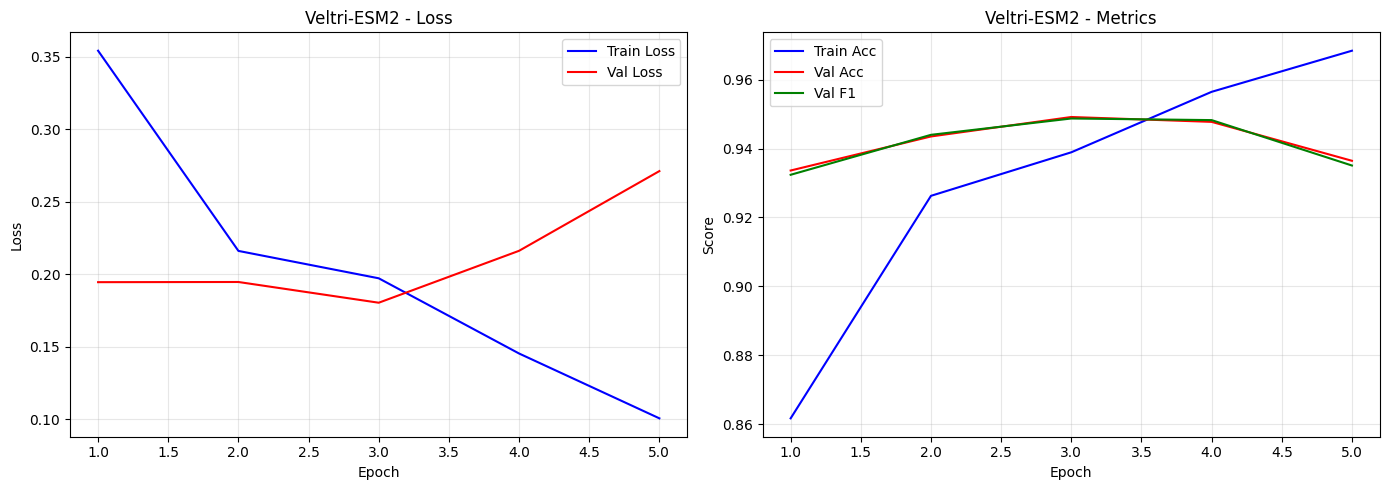


✓ Model saved to 'esm2_veltri_model.pth'


In [ ]:
# Train on Veltri dataset
print("\n" + "="*80)
print("TRAINING ESM-2 ON VELTRI DATASET")
print("="*80)

veltri_model, veltri_history, veltri_results = train_esm2_model(
    veltri_train,
    veltri_val,
    veltri_test,
    dataset_name="Veltri",
    model_name="facebook/esm2_t6_8M_UR50D",  # Small/fast model
    batch_size=8,
    epochs=5,
    learning_rate=2e-5,
    freeze_esm=False,
    use_scheduler=False     # No scheduler for Veltri
)

plot_training_history(veltri_history, "Veltri-ESM2")
torch.save(veltri_model.state_dict(), 'esm2_veltri_model.pth')
print("\n✓ Model saved to 'esm2_veltri_model.pth'")


TRAINING ESM-2 ON LMPRED DATASET

Training ESM-2 Model: LMPred
Model: facebook/esm2_t6_8M_UR50D
Batch size: 4
Epochs: 5
Learning rate: 1e-06
Freeze ESM: False
Use scheduler: True

Loading ESM-2 tokenizer...
Creating datasets...

Initializing ESM-2 model...


Loading weights:   0%|          | 0/107 [00:00<?, ?it/s]

EsmModel LOAD REPORT from: facebook/esm2_t6_8M_UR50D
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
esm.embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias           | MISSING    | 
pooler.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


ESM-2 model: facebook/esm2_t6_8M_UR50D
Hidden size: 320

Starting training...

Epoch 1/5
------------------------------------------------------------


Training:   0%|          | 0/752 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/376 [00:00<?, ?it/s]


Train Loss: 0.6479, Train Acc: 0.6126
Val Loss: 0.5619, Val Acc: 0.8132
Val F1: 0.8133, Val AUC: 0.8768
Current LR: 1.00e-06
✓ New best model! (F1: 0.8133)

Epoch 2/5
------------------------------------------------------------


Training:   0%|          | 0/752 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/376 [00:00<?, ?it/s]


Train Loss: 0.4734, Train Acc: 0.8226
Val Loss: 0.4113, Val Acc: 0.8338
Val F1: 0.8302, Val AUC: 0.9011
Current LR: 1.00e-06
✓ New best model! (F1: 0.8302)

Epoch 3/5
------------------------------------------------------------


Training:   0%|          | 0/752 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/376 [00:00<?, ?it/s]


Train Loss: 0.3776, Train Acc: 0.8439
Val Loss: 0.3732, Val Acc: 0.8497
Val F1: 0.8458, Val AUC: 0.9117
Current LR: 1.00e-06
✓ New best model! (F1: 0.8458)

Epoch 4/5
------------------------------------------------------------


Training:   0%|          | 0/752 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/376 [00:00<?, ?it/s]


Train Loss: 0.3568, Train Acc: 0.8589
Val Loss: 0.3772, Val Acc: 0.8644
Val F1: 0.8636, Val AUC: 0.9149
Current LR: 1.00e-06
✓ New best model! (F1: 0.8636)

Epoch 5/5
------------------------------------------------------------


Training:   0%|          | 0/752 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/376 [00:00<?, ?it/s]


Train Loss: 0.3609, Train Acc: 0.8676
Val Loss: 0.3840, Val Acc: 0.8723
Val F1: 0.8722, Val AUC: 0.9187
Current LR: 1.00e-06
✓ New best model! (F1: 0.8722)

Loading best model for testing...

Evaluating on test set...


Evaluating:   0%|          | 0/752 [00:00<?, ?it/s]


TEST RESULTS
Loss           : 0.4208
Accuracy       : 0.8470
Precision      : 0.8545
Recall         : 0.8363
F1             : 0.8453
Auc            : 0.9148
Sensitivity    : 0.8363
Specificity    : 0.8577


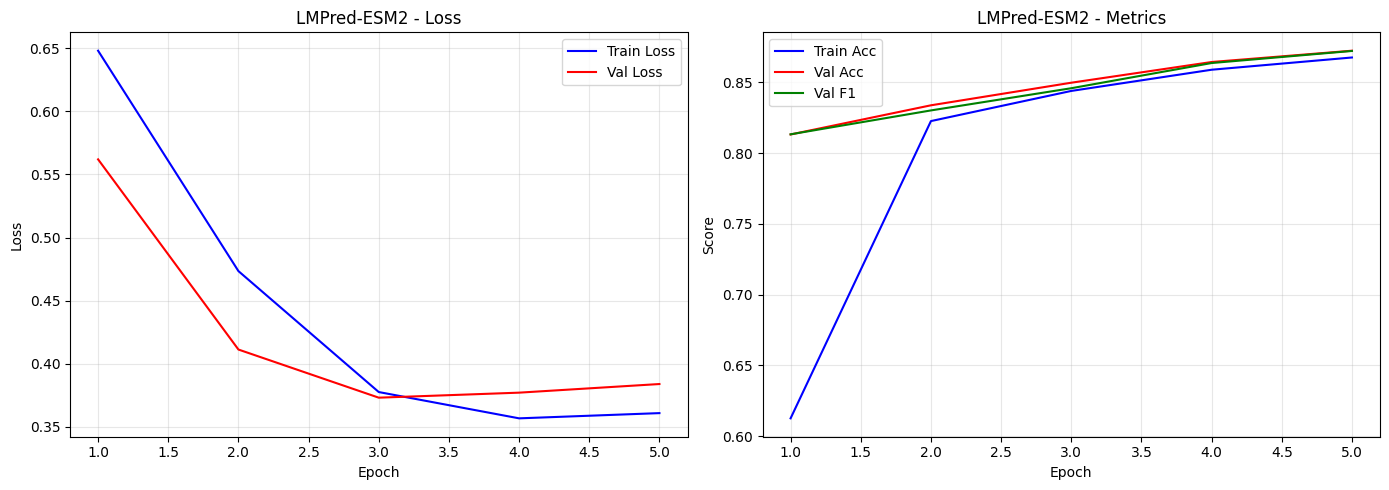


✓ Model saved to 'esm2_lmpred_model.pth'


In [ ]:
# Clear memory before LMPred
gc.collect()
torch.cuda.empty_cache()

# Train on LMPred dataset
print("\n" + "="*80)
print("TRAINING ESM-2 ON LMPRED DATASET")
print("="*80)

lmpred_model, lmpred_history, lmpred_results = train_esm2_model(
    lmpred_train,
    lmpred_val,
    lmpred_test,
    dataset_name="LMPred",
    model_name="facebook/esm2_t6_8M_UR50D",  # Same model
    batch_size=4,           # Smaller batch
    epochs=5,
    learning_rate=1e-6,     # Ultra low LR for stability
    freeze_esm=False,
    use_scheduler=True      # Use scheduler for LMPred
)

plot_training_history(lmpred_history, "LMPred-ESM2")
torch.save(lmpred_model.state_dict(), 'esm2_lmpred_model.pth')
print("\n✓ Model saved to 'esm2_lmpred_model.pth'")


COMPARISON: Baseline vs ProtBERT vs ESM-2
            Model Dataset  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_AUC
Baseline-LR (k=3)  Veltri       0.827949        0.822069     0.837079 0.829506  0.906779
Baseline-LR (k=3)  LMPred       0.749917        0.741479     0.767132 0.754088  0.814845
         ProtBERT  Veltri       0.859551        0.892638     0.817416 0.853372  0.921190
         ProtBERT  LMPred       0.868640        0.849747     0.895542 0.872044  0.930630
            ESM-2  Veltri       0.924157        0.953453     0.891854 0.921626  0.971142
            ESM-2  LMPred       0.847024        0.854521     0.836327 0.845326  0.914773


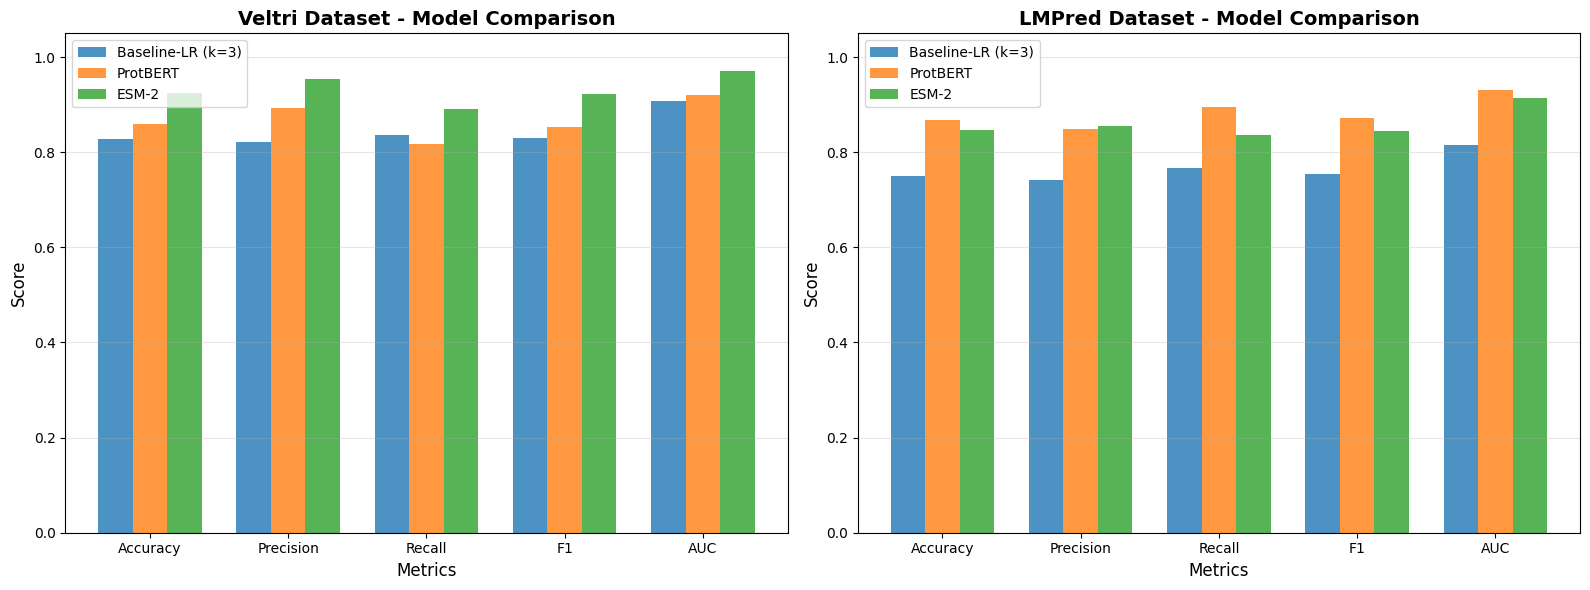

In [ ]:
# Load previous results
baseline_protbert_results = pd.read_csv('results_baseline_protbert.csv')

# Create ESM-2 results
esm2_results_df = pd.DataFrame({
    'Model': ['ESM-2'] * 2,
    'Dataset': ['Veltri', 'LMPred'],
    'Test_Accuracy': [veltri_results['accuracy'], lmpred_results['accuracy']],
    'Test_Precision': [veltri_results['precision'], lmpred_results['precision']],
    'Test_Recall': [veltri_results['recall'], lmpred_results['recall']],
    'Test_F1': [veltri_results['f1'], lmpred_results['f1']],
    'Test_AUC': [veltri_results['auc'], lmpred_results['auc']]
})

# Combine all results
all_results = pd.concat([baseline_protbert_results, esm2_results_df], ignore_index=True)

print("\n" + "="*80)
print("COMPARISON: Baseline vs ProtBERT vs ESM-2")
print("="*80)
print(all_results.to_string(index=False))

# Save combined results
all_results.to_csv('results_all_models.csv', index=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, dataset in enumerate(['Veltri', 'LMPred']):
    data = all_results[all_results['Dataset'] == dataset]

    metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

    x = np.arange(len(metrics))
    width = 0.25

    models = data['Model'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, model in enumerate(models):
        model_data = data[data['Model'] == model]
        scores = model_data[metrics].values[0]
        axes[idx].bar(x + i*width - width, scores, width, label=model, alpha=0.8, color=colors[i])

    axes[idx].set_xlabel('Metrics', fontsize=12)
    axes[idx].set_ylabel('Score', fontsize=12)
    axes[idx].set_title(f'{dataset} Dataset - Model Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(metric_labels)
    axes[idx].legend()
    axes[idx].set_ylim([0, 1.05])
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()